# Predicting Question Pairs in Discussion Forums using MaLSTM network

### I. Environment Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = 'drive/MyDrive/Colab Notebooks'
# %cd $path

In [4]:
# ! pip install gensim==3.8.3 --user

In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from tensorflow.keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### II. Preprocess Datasets

In [4]:
import os
os.listdir()

['.ipynb_checkpoints',
 'models',
 'plots',
 'pred_output.csv',
 'Project Proposal.docx',
 'Project Proposal.pdf',
 'Project_Guidelines.pdf',
 'QuestionPairs_MaLSTM.ipynb',
 'quora-question-pairs']

In [5]:
train_path = './quora-question-pairs/train.csv'
test_path = './quora-question-pairs/test.csv'

embedding_file = r'C:\Users\siddh\Downloads\GoogleNews-vectors-negative300.bin'
# model_saving_dir = '/home/ecohen/HDD/HDD4/Models/Kaggle/Quora/'

In [6]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

### III. Generate Embeddings

In [7]:
vocabulary = dict()
inverse_vocabulary = ['<unknown>']  # '<unknown>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(embedding_file, binary=True)

questions_cols = ['question1', 'question2']

In [8]:
# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.at[index, question] = q2n

In [9]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

### IV. Prepare Training & Validation Data

In [10]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# manual_seq_length = 213        
        
# Split to train validation
test_size = 40000
training_size = len(train_df) - test_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_test = {'left': X_test.question1, 'right': X_test.question2}
# X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_test = Y_test.values

# Zero padding
for dataset, side in itertools.product([X_train, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

### V. Build Model

In [15]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [11]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 10
lr = 0.001

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(clipnorm=gradient_clipping_norm, lr=lr)

malstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

C:\Users\siddh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
malstm.optimizer.get_config()

{'name': 'Adam',
 'clipnorm': 1.25,
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [18]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_test['left'], X_test['right']], Y_test))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/10
5693/5693 [==============================] - 1467s 257ms/step - loss: 0.5037 - accuracy: 0.7609 - val_loss: 0.4692 - val_accuracy: 0.7781
Epoch 2/10
5693/5693 [==============================] - 1400s 246ms/step - loss: 0.4527 - accuracy: 0.7905 - val_loss: 0.4494 - val_accuracy: 0.7944
Epoch 3/10
5693/5693 [==============================] - 1399s 246ms/step - loss: 0.4337 - accuracy: 0.8009 - val_loss: 0.4400 - val_accuracy: 0.8033
Epoch 4/10
5693/5693 [==============================] - 1528s 268ms/step - loss: 0.4197 - accuracy: 0.8095 - val_loss: 0.4327 - val_accuracy: 0.8033
Epoch 5/10
5693/5693 [==============================] - 1406s 247ms/step - loss: 0.4099 - accuracy: 0.8149 - val_loss: 0.4253 - val_accuracy: 0.8080
Epoch 6/10
5693/5693 [==============================] - 1634s 287ms/step - loss: 0.4022 - accuracy: 0.8193 - val_loss: 0.4224 - val_accuracy: 0.8109
Epoch 7/10
5693/5693 [==============================] - 1682s 295ms/step - loss: 0.3957 - accuracy: 0.8229

### Save model and training history

In [19]:
print(malstm_trained.history)

{'loss': [0.5036944150924683, 0.4526798725128174, 0.43374085426330566, 0.4197349548339844, 0.40990710258483887, 0.40218585729599, 0.39567214250564575, 0.38984736800193787, 0.38479894399642944, 0.38023677468299866], 'accuracy': [0.7609267234802246, 0.7904608845710754, 0.8009278178215027, 0.8094704747200012, 0.8148919939994812, 0.8192813396453857, 0.8228938579559326, 0.8261357545852661, 0.8286502361297607, 0.8307117819786072], 'val_loss': [0.469163179397583, 0.44943949580192566, 0.4399891495704651, 0.43265634775161743, 0.4253295063972473, 0.4223763048648834, 0.4198516011238098, 0.42097899317741394, 0.4162590205669403, 0.4168676733970642], 'val_accuracy': [0.7781000137329102, 0.7943750023841858, 0.8032749891281128, 0.8032749891281128, 0.8080000281333923, 0.8108749985694885, 0.8129749894142151, 0.8127250075340271, 0.8167999982833862, 0.8187249898910522]}


In [20]:
# convert the malstm_trained.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(malstm_trained.history) 
hist_df.to_csv('./models/malstm-2.csv')

malstm.save('./models/malstm-2.h5')

In [21]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.503694,0.760927,0.469163,0.778100
1,0.452680,0.790461,0.449439,0.794375
2,0.433741,0.800928,0.439989,0.803275
3,0.419735,0.809470,0.432656,0.803275
4,0.409907,0.814892,0.425330,0.808000
5,0.402186,0.819281,0.422376,0.810875
6,0.395672,0.822894,0.419852,0.812975
7,0.389847,0.826136,0.420979,0.812725
8,0.384799,0.828650,0.416259,0.816800
9,0.380237,0.830712,0.416868,0.818725


In [1]:
# Plot accuracy
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

NameError: name 'plt' is not defined

### Load model

In [13]:
from keras.models import load_model
model1 = load_model('./models/malstm-2.h5')
model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Model Testing

In [17]:
y_pred = model1.predict([X_test['left'], X_test['right']])

In [18]:
test_loss, test_acc = model1.evaluate([X_test['left'], X_test['right']], Y_test)

# print("Test loss = {:.3f} and Test Accuracy = {:.3f}".format(test_loss, test_acc))

1250/1250 [==============================] - 88s 70ms/step - loss: 0.3751 - accuracy: 0.8348


In [22]:
y_labels = np.array([1 if l > 0.5 else 0 for l in y_pred])
y_labels

array([0, 0, 0, ..., 0, 0, 0])

[[22914  2238]
 [ 4370 10478]]


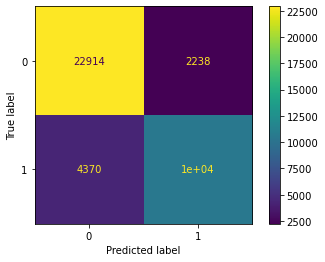

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_labels)
print(cm)

cmd_obj = ConfusionMatrixDisplay(cm)
cmd_obj.plot()

### Model Testing (Unlabelled Data)

In [64]:
n = 100000
X1 = test_df[questions_cols][:n]

# Split to dicts
X_test1 = {'left': X1.question1, 'right': X1.question2}

# Zero padding
for dataset, side in itertools.product([X_test1], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_test1['left'].shape == X_test1['right'].shape

In [65]:
y_pred1 = malstm.predict([X_test1['left'], X_test1['right']])

In [67]:
df1 = pd.read_csv(test_path, nrows=n)
df1 = df1.merge(pd.Series(y_pred1.reshape(n, ), name='y_pred'), left_index=True, right_index=True)
df1['label'] = [1 if l > 0.5 else 0 for l in df.y_pred]

# df1.to_csv('pred_output.csv', index=False)